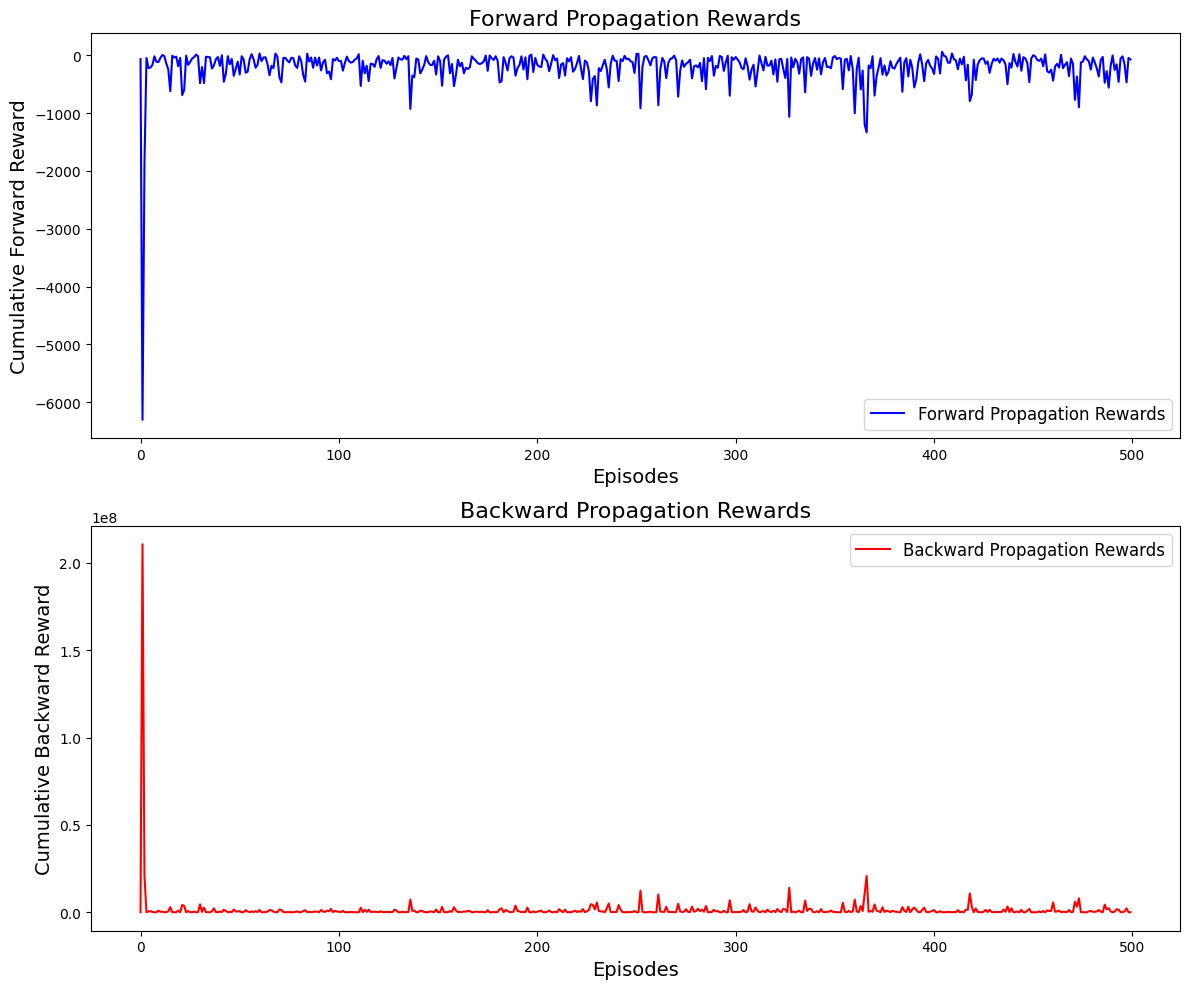

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Grid World Configuration
BOARD_ROWS = 5
BOARD_COLS = 5

# Special State Coordinates
WIN_STATE = (4, 4)      # Goal state
JUMP_STATE = (1, 3)     # Special state with higher reward
START = (1, 0)          # Starting position
OBSTACLES = [(2, 2), (2, 3), (2, 4), (3, 2)]  # Blocked cells

class State:
    def __init__(self, state=START):
        """
        Initialize the grid world state
        
        Args:
            state (tuple): Initial position of the agent
        """
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.board[1, 1] = -1  # Mark initial obstacle
        self.state = state
        self.isEnd = False

    def give_reward(self):
        """
        Provide reward based on current state
        
        Returns:
            int: Reward value
        """
        if self.state == WIN_STATE:
            return +10  # Large reward for reaching goal
        elif self.state == JUMP_STATE:
            return +5   # Medium reward for special jump state
        else:
            return -1   # Small negative reward to encourage efficient paths

    def is_end_func(self):
        """
        Check if current state is the end state
        """
        if self.state == WIN_STATE:
            self.isEnd = True

    def nxt_position(self, action):
        """
        Determine next position based on action
        
        Args:
            action (str): Movement action
        
        Returns:
            tuple: Next state coordinates
        """
        # Define next state based on action
        if action == "up":
            nxt_state = (self.state[0] - 1, self.state[1])
        elif action == "down":
            nxt_state = (self.state[0] + 1, self.state[1])
        elif action == "left":
            nxt_state = (self.state[0], self.state[1] - 1)
        elif action == "jump":
            nxt_state = (self.state[0] + 2, self.state[1])
        else:  # right
            nxt_state = (self.state[0], self.state[1] + 1)

        # Validate next state (within bounds and not an obstacle)
        if (0 <= nxt_state[0] < BOARD_ROWS and 
            0 <= nxt_state[1] < BOARD_COLS and 
            nxt_state not in OBSTACLES):
            return nxt_state
        
        # Return current state if move is invalid
        return self.state

class Agent:
    def __init__(self, learning_rate=0.3, exploration_rate=0.3):
        """
        Initialize Q-learning agent with additional tracking for forward and backward propagation
        
        Args:
            learning_rate (float): Rate of learning from rewards
            exploration_rate (float): Probability of exploring random actions
        """
        self.states = []
        self.actions = ["up", "down", "left", "right", "jump"]
        self.State = State()
        
        # Learning parameters
        self.lr = learning_rate
        self.exp_rate = exploration_rate
        
        # Initialize state values
        self.state_values = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.state_values[(i, j)] = 0

        # New tracking for forward and backward propagation
        self.forward_rewards = []
        self.backward_rewards = []

    def choose_action(self):
        """
        Select action using epsilon-greedy strategy
        
        Returns:
            str: Selected action
        """
        # Exploration: random action
        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
            # Ensure 'jump' is only used at specific state
            while action == 'jump' and self.State.state != JUMP_STATE:
                action = np.random.choice(self.actions)
            return action
        
        # Exploitation: choose best known action
        mx_nxt_reward = float('-inf')
        action = ""
        
        for a in self.actions:
            # Skip invalid actions
            if self.State.nxt_position(a) == self.State.state:
                continue
            
            # Skip jump if not at jump state
            if a == "jump" and self.State.state != JUMP_STATE:
                continue
            
            # Find action with maximum next reward
            nxt_reward = self.state_values[self.State.nxt_position(a)]
            if nxt_reward > mx_nxt_reward:
                action = a
                mx_nxt_reward = nxt_reward
        
        return action

    def take_action(self, action):
        """
        Execute action and transition to next state
        
        Args:
            action (str): Action to take
        
        Returns:
            State: New state after action
        """
        position = self.State.nxt_position(action)
        return State(state=position)

    def reset(self):
        """
        Reset agent for a new episode
        """
        self.states = []
        self.State = State()

    def play(self, rounds=100):
        """
        Train agent with separate tracking of forward and backward propagation
        
        Args:
            rounds (int): Number of training episodes
        
        Returns:
            tuple: Lists of forward and backward rewards
        """
        total_forward_rewards = []
        total_backward_rewards = []

        for i in range(rounds):
            # Reset for each episode
            self.states = []
            self.State = State()
            forward_episode_rewards = []
            backward_episode_rewards = []
            last_reward = 0
            
            # Forward Propagation (Learning Phase)
            while not self.State.isEnd:
                # Choose and take action
                action = self.choose_action()
                self.states.append(self.State.nxt_position(action))
                
                # Transition to next state
                self.State = self.take_action(action)
                self.State.is_end_func()
                
                # Get and track forward reward
                reward = self.State.give_reward()
                forward_episode_rewards.append(reward)
                last_reward = reward
            
            # Backward Propagation (Value Update Phase)
            total_backward_reward = 0
            for s in reversed(self.states):
                # Update state value with learning rate
                reward = self.state_values[s] + self.lr * (last_reward - self.state_values[s])
                self.state_values[s] = round(reward, 4)
                total_backward_reward += reward
                backward_episode_rewards.append(total_backward_reward)
            
            # Store rewards for plotting
            total_forward_rewards.append(np.sum(forward_episode_rewards))
            total_backward_rewards.append(np.sum(backward_episode_rewards))

        return total_forward_rewards, total_backward_rewards

    def plot_propagation_comparison(self, rounds=500):
        """
        Plot forward and backward propagation rewards
        
        Args:
            rounds (int): Number of training episodes to simulate
        """
        # Create two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Line chart for forward and backward rewards
        forward_rewards, backward_rewards = self.play(rounds)
        
        # Forward Propagation Rewards
        ax1.plot(forward_rewards, label='Forward Propagation Rewards', color='blue')
        ax1.set_title('Forward Propagation Rewards', fontsize=16)
        ax1.set_xlabel('Episodes', fontsize=14)
        ax1.set_ylabel('Cumulative Forward Reward', fontsize=14)
        ax1.legend(fontsize=12)
        
        # Backward Propagation Rewards
        ax2.plot(backward_rewards, label='Backward Propagation Rewards', color='red')
        ax2.set_title('Backward Propagation Rewards', fontsize=16)
        ax2.set_xlabel('Episodes', fontsize=14)
        ax2.set_ylabel('Cumulative Backward Reward', fontsize=14)
        ax2.legend(fontsize=12)
        
        plt.tight_layout()
        plt.show()


# Main execution
if __name__ == "__main__":
    # Create agent and plot propagation comparison
    agent = Agent()
    agent.plot_propagation_comparison(rounds=500)